# Import Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 
import datetime as dt 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go 
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer

# Read the file

In [2]:
df = pd.read_csv('data.csv', header=0, encoding='unicode_escape',dtype={'CustomerID' : str}, parse_dates=['InvoiceDate'], infer_datetime_format=True)
display(df.head(10))
print(len(df))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom


541909


## Make a summary

In [44]:

def summary(df, num_rows=3):

    """
    Generate a summary of the DataFrame.

    Parameters:
    - df: Dataframe
    - num_rows: Number of rows to display

    Returns:
    - DataFrame containing summury
    """

    #numeric_collumns = df.select_dtypes(include=['number']).columns

    # Basic information
    print(f'Data shape: {df.shape}')

    # Data types, missing values, and unique values
    data_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing': df.isnull().sum(),
        'Percent Missing': df.isnull().mean() * 100,
        'Unique Values': df.nunique()
    })

    # Descriptive statistics
    desc_stats = df.describe(include='all').transpose()

    #  # Extract n values for each row
    row_values = pd.DataFrame()
    for i in range(num_rows):
        row_values[f'Value-{i + 1}'] = df.iloc[i]
    
    # Combine the information

    summary_df = pd.concat([data_info, desc_stats[['min', 'max']], row_values], axis=1)
   
    return summary_df

df_summary = summary(df)
display(df_summary)

# Quantity with missing values
quantity = pd.DataFrame([{'Products' : len(df['StockCode'].value_counts()), 
                          'Customers' : (df['CustomerID'].nunique()),
                          'Transactions' : len(df['InvoiceNo'].value_counts()),
                          }],
             columns=['Products', 'Customers', 'Transactions'], index=['Quantity']) # Names in columns should match
print(quantity)

Data shape: (541909, 8)


,Data Type,Missing,Percent Missing,Unique Values,min,max,Value-1,Value-2,Value-3
InvoiceNo,object,0,0.000000,25900,NaN,NaN,536365,536365,536365
StockCode,object,0,0.000000,4070,NaN,NaN,85123A,71053,84406B
Description,object,1454,0.268311,4223,NaN,NaN,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER
Quantity,int64,0,0.000000,722,-80995.0,80995.0,6,6,8
InvoiceDate,datetime64[ns],0,0.000000,23260,2010-12-01 08:26:00,2011-12-09 12:50:00,2010-12-01 08:26:00,2010-12-01 08:26:00,2010-12-01 08:26:00
UnitPrice,float64,0,0.000000,1630,-11062.06,38970.0,2.55,3.39,2.75
CustomerID,object,135080,24.926694,4372,NaN,NaN,17850,17850,17850
Country,object,0,0.000000,38,NaN,NaN,United Kingdom,United Kingdom,United Kingdom


          Products  Customers  Transactions
Quantity      4070       4372         25900


## Census of the cancel orders and check for the existence of counterparts:
## Till later....

In [35]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    #_________________________________
    # Identify Cancelation Without Counterpart:
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Identify Cancelation With a Single Counterpart:
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity'] # Assign - value to each row of a column
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Identify Cancelation With Multiple Counterparts:
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break           

### Table analys (rename later)

In [47]:
def replace_with_tresholds(Dataframe, variable, q1 = 0.25, q3 = 0.75):
    df_copy = Dataframe.copy()
    quartile1, quartile3 = df_copy[variable].quantile([q1, q3])
    iqr = quartile3 - quartile1

    lower_limit = quartile3 + 1.5 * iqr
    upper_limit = quartile3 - 1.5 * iqr

    df_copy[variable] = df_copy[variable].clip(lower=lower_limit, upper=upper_limit )

    return df_copy

def preprocess(DataFrame):
    df = DataFrame.copy()

    # Missing values
    print(df.isnull().sum())

    # Remove missing values
    df = df.dropna()

    # Cancelled Orders & Quantity
    display(df[~df['InvoiceNo'].str.contains('C', na=False)].head(5))
    df = df[~df['InvoiceNo'].str.contains('C', na=False)]

    df = df[df['Quantity'] > 0]

    # Replacing Outliers
    variables_for_process = ['Quantity', 'UnitPrice']
    for variable in variables_for_process:
        df = replace_with_tresholds(df, variable, q1=0.01, q3=0.99)

    # Total Price
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice'] # New column
    
    return df

df_preprocessed = preprocess(df)
display(df_preprocessed)


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-12-09 12:50:00,4.15,12680,France,16.60


## EDA

## Highest

In [5]:
purchase = df_preprocessed.groupby(['Country'], as_index=False)['TotalPrice'].agg('sum')
print(purchase.head(5))

top_purchased_countries = purchase.sort_values('TotalPrice', ascending=False).head(10)
print((top_purchased_countries))

fig = go.Figure(data=[go.Bar(x=top_purchased_countries['Country'].astype(str),
                             y=top_purchased_countries['TotalPrice'], 
                             marker={'color' : top_purchased_countries['TotalPrice']},
                             texttemplate='£%{y:.3s}',
                             textposition='outside'
                             )])

fig.update_layout(
    title='Countries With Highest Purchase History',
    title_x=0.5,
    xaxis_title='Countries',
    yaxis_title='Total Amount',
    plot_bgcolor='white',
    barmode='relative', # 'relative for stacked bars
    bargap=0.20, # Gap between bars
    showlegend=False,
    width=800,
    height=700,
)

fig.show()

     Country  TotalPrice
0  Australia   133750.01
1    Austria    10095.78
2    Bahrain      548.40
3    Belgium    41193.45
4     Brazil     1143.60
           Country   TotalPrice
35  United Kingdom  6680094.499
23     Netherlands   271400.955
10            EIRE   259055.530
14         Germany   225722.770
13          France   197386.075
0        Australia   133750.010
30           Spain    60393.425
32     Switzerland    56149.950
3          Belgium    41193.450
31          Sweden    35345.705


## Lowest

In [6]:

min_purchased_countries = purchase.sort_values('TotalPrice').head(10)
print((min_purchased_countries))

fig = go.Figure(data=[go.Bar(x=min_purchased_countries['Country'].astype(str),
                             y=min_purchased_countries['TotalPrice'], 
                             marker={'color' : min_purchased_countries['TotalPrice']},
                             texttemplate='£%{y:.3s}',
                             textposition='outside'
                             )])

fig.update_layout(
    title='Countries With Minimum Purchase History',
    title_x=0.5,
    xaxis_title='Countries',
    yaxis_title='Total Amount',
    plot_bgcolor='white',
    barmode='relative', # 'relative for stacked bars
    bargap=0.20, # Gap between bars
    showlegend=False,
    width=800,
    height=700,
)

fig.show()

                 Country  TotalPrice
28          Saudi Arabia      145.92
2                Bahrain      548.40
8         Czech Republic      823.80
27                   RSA     1002.31
4                 Brazil     1143.60
11    European Community     1300.25
21             Lithuania     1661.06
20               Lebanon     1693.88
34  United Arab Emirates     1901.84
22                 Malta     2515.31


## Top 10 Products

In [7]:
products = df.pivot_table(index="Description", values="Quantity", aggfunc=np.sum).reset_index()
top_products = products.sort_values("Quantity", ascending=False).head(10)
display(top_products)

fig = go.Figure(data=[go.Bar(x=top_products['Description'].astype(str),
                             y=top_products['Quantity'], 
                             marker={'color' : top_products['Quantity'],
                                     'colorscale' : 'viridis'},
                             texttemplate='£%{y:.3s}',
                             textposition='outside',
                             )])

fig.update_layout(
    title='Top 10 Purchased Products',
    title_x=0.5,
    xaxis_title='Description',
    yaxis_title='Quantity',
    plot_bgcolor='white',
    barmode='relative', # 'relative for stacked bars
    bargap=0.20, # Gap between bars
    width=800,
    height=700,
)

fig.update_xaxes(tickangle=20) # Rotates the x-axis labels

fig.show()

,Description,Quantity
4009,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
1866,JUMBO BAG RED RETROSPOT,47363
244,ASSORTED COLOUR BIRD ORNAMENT,36381
2740,POPCORN HOLDER,36334
2395,PACK OF 72 RETROSPOT CAKE CASES,36039
3918,WHITE HANGING HEART T-LIGHT HOLDER,35317
2803,RABBIT NIGHT LIGHT,30680
2161,MINI PAINT SET VINTAGE,26437
2361,PACK OF 12 LONDON TISSUES,26315
2393,PACK OF 60 PINK PAISLEY CAKE CASES,24753


## Best Customers 

In [10]:
display(df_preprocessed)
customers = df_preprocessed.groupby(["CustomerID", "Country"], as_index=False)["TotalPrice"].agg('sum')
best_customers = customers.sort_values("TotalPrice", ascending=False).head(10)
best_customers

fig = go.Figure(data=[go.Bar(x=best_customers["CustomerID"].astype(str),
                             y=best_customers['TotalPrice'], 
                             hovertext=best_customers["Country"],
                             marker={'color' : best_customers['TotalPrice'],
                                     'colorscale' : 'viridis'},
                             texttemplate='£%{y:.3s}',
                             textposition='outside',
                             )])

fig.update_traces(textposition="inside")

fig.update_layout(
    title='Top 10 Best Customers',
    title_x=0.5,
    xaxis_title='CustomerID',
    yaxis_title='Money Spent',
    plot_bgcolor='white',
    barmode='relative', # 'relative for stacked bars
    bargap=0.2, # Gap between bars
    width=800,
    height=700,
)

fig.update_xaxes(tickangle=0) # Rotates the x-axis labels

fig.show()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-12-09 12:50:00,4.15,12680,France,16.60


## Worst Customers

In [9]:
display(df_preprocessed)
worst_customers = customers.sort_values("TotalPrice").head(10)
worst_customers
fig = go.Figure(data=[go.Bar(x=worst_customers["CustomerID"].astype(str),
                             y=worst_customers['TotalPrice'], 
                             hovertext=worst_customers["Country"],
                             marker={'color' : worst_customers['TotalPrice'],
                                     'colorscale' : 'viridis'},
                             texttemplate='£%{y:.3s}',
                             textposition='outside',
                             )])

fig.update_traces(textposition="inside")

fig.update_layout(
    title='Top 10 Worst Customers',
    title_x=0.5,
    xaxis_title='CustomerID',
    yaxis_title='Money Spent',
    plot_bgcolor='white',
    barmode='relative', # 'relative for stacked bars
    bargap=0.2, # Gap between bars
    width=800,
    height=700,
)

fig.update_xaxes(tickangle=0) # Rotates the x-axis labels

fig.show()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-12-09 12:50:00,4.15,12680,France,16.60


## Number of products per Customer

In [33]:
# Without canceled 
temp1 = df_preprocessed.groupby(["CustomerID", "InvoiceNo"], as_index=False)["InvoiceDate"].count()
products_per_basket = temp1.rename(columns={"InvoiceDate" : "Number of products"})
result = products_per_basket[ : 10].sort_values("CustomerID")
display(result)
print(result.count())

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12347,537626,31
2,12347,542237,29
3,12347,549222,24
4,12347,556201,18
5,12347,562032,22
6,12347,573511,47
7,12347,581180,11
8,12348,539318,17
9,12348,541998,6


CustomerID            10
InvoiceNo             10
Number of products    10
dtype: int64


## Anomalies Detection

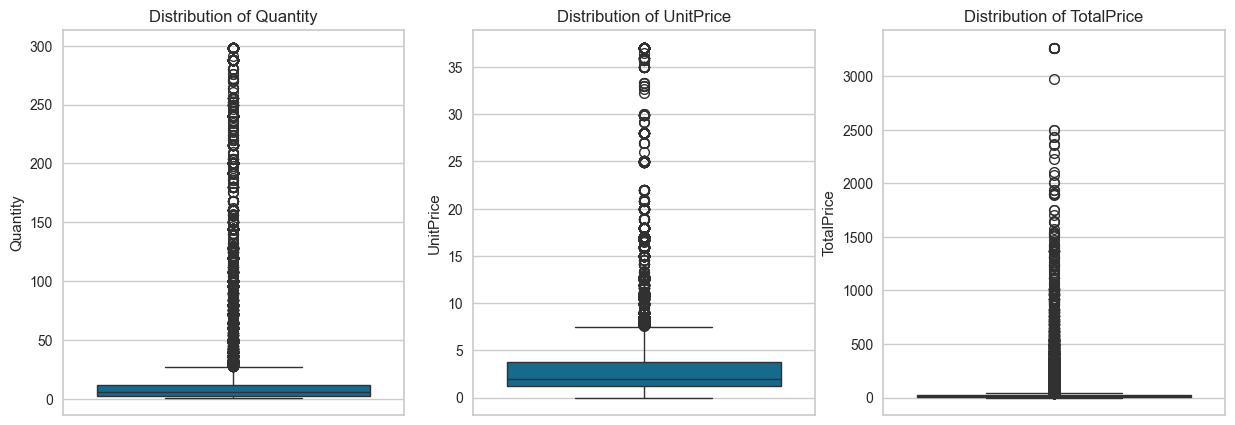

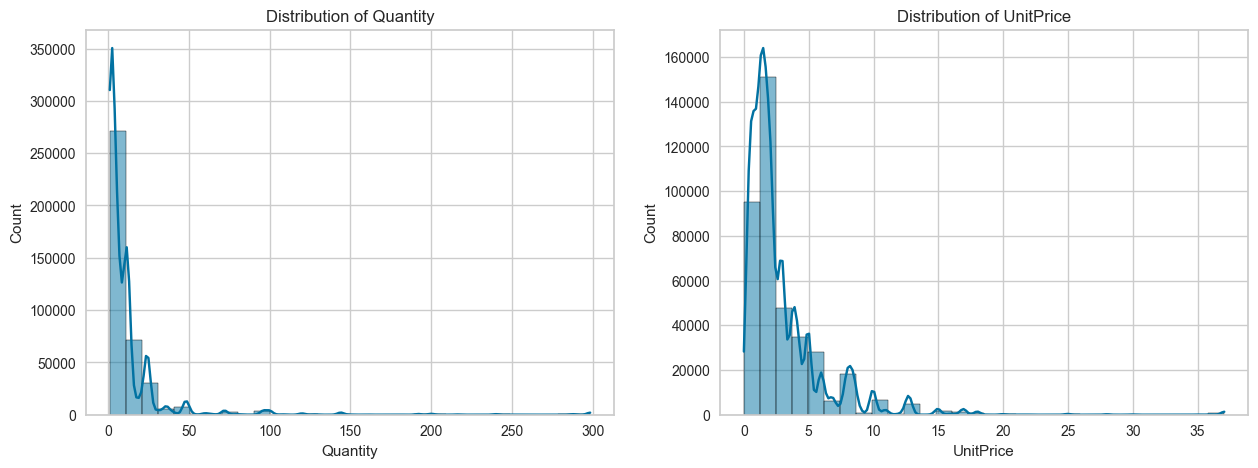

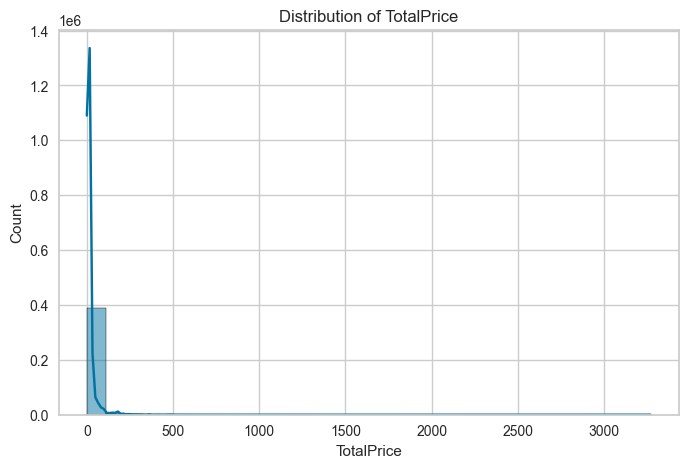

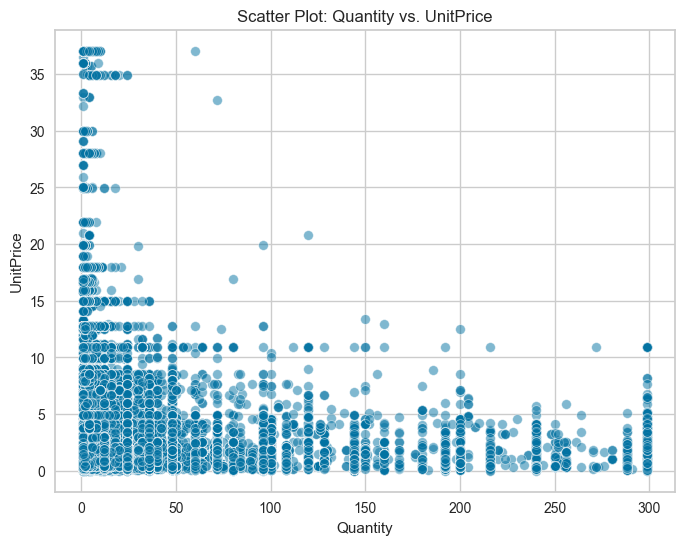

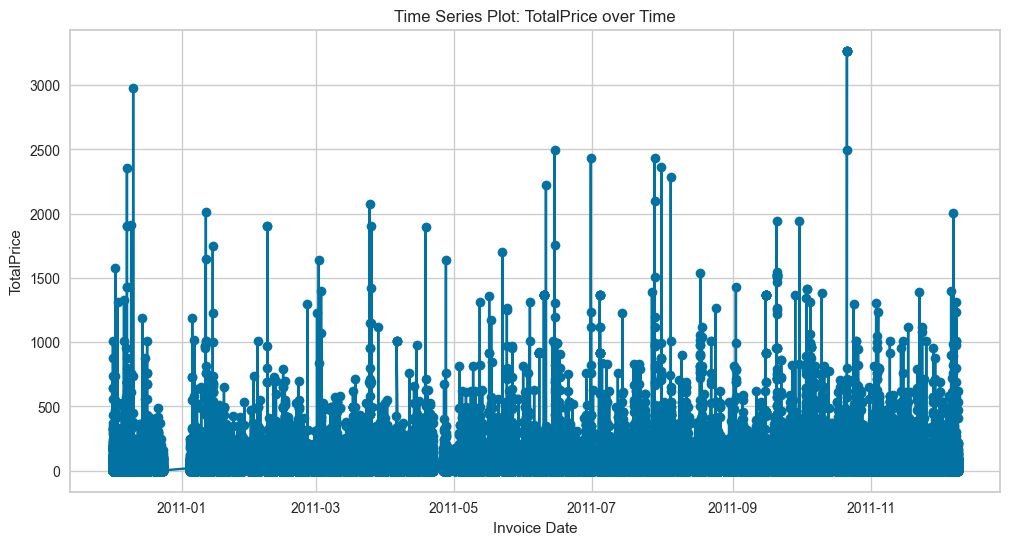

In [20]:
# # Numeric variables for exploration
# numeric_variables = ['Quantity', 'UnitPrice', 'TotalPrice']

# # Box plots for each numeric variable
# plt.figure(figsize=(15, 5))
# for i, variable in enumerate(numeric_variables, 1):
#     plt.subplot(1, 3, i)
#     sns.boxplot(data=df_preprocessed, y=variable)
#     plt.title(f'Distribution of {variable}')
# plt.show()


# # Histograms for Quantity and UnitPrice
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 2, 1)
# sns.histplot(df_preprocessed['Quantity'], bins=30, kde=True)
# plt.title('Distribution of Quantity')

# plt.subplot(1, 2, 2)
# sns.histplot(df_preprocessed['UnitPrice'], bins=30, kde=True)
# plt.title('Distribution of UnitPrice')

# plt.show()

# # Distribution of TotalPrice
# plt.figure(figsize=(8, 5))
# sns.histplot(df_preprocessed['TotalPrice'], bins=30, kde=True)
# plt.title('Distribution of TotalPrice')
# plt.show()

# # Scatter plot for Quantity vs. UnitPrice
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df_preprocessed, x='Quantity', y='UnitPrice', alpha=0.5)
# plt.title('Scatter Plot: Quantity vs. UnitPrice')
# plt.show()


# # Time series plot for TotalPrice
# plt.figure(figsize=(12, 6))
# plt.plot(df_preprocessed['InvoiceDate'], df_preprocessed['TotalPrice'], marker='o', linestyle='-')
# plt.title('Time Series Plot: TotalPrice over Time')
# plt.xlabel('Invoice Date')
# plt.ylabel('TotalPrice')
# plt.show()



# RFM Analysis?

# Insight on product categories